<a href="https://colab.research.google.com/github/namwootree/Basic_Skill/blob/main/Time_Series/%EA%B8%88%EC%9C%B5%20%ED%8C%8C%EC%9D%B4%EC%8D%AC%20%EC%BF%A1%EB%B6%81/4%EC%9E%A5_%EB%8B%A4%ED%8C%A9%ED%84%B0_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [65]:
import numpy as np
import pandas as pd

import yfinance as yf
import pandas_datareader.data as web
from pandas_datareader.famafrench import get_available_datasets

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

In [72]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [4, 2]
plt.rcParams['figure.dpi'] = 300

# Factor Model


* 하나 이상의 팩터를 사용해 특정 포트폴리오나 자산의 초과 수익을 설명하는 것이다
* 투자 포트폴리오에 추가될 수 있는 흥미로운 자산을 식별하는데 사용할 수 있으며, 결과적으로 포트폴리오의 실적을 향상시킨다

# 파이썬으로 CAPM 구현

**자본 자산 가격 모델**

* 위험 자산에 대한 예상 수익률과 시장 위험 간의 관계를 나타낸다

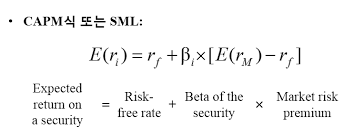

**베타**

* 시장 대비 자산 수익률의 민감도 수준

* beta <= -1 : 자산이 벤치 마크와 반대 방향이며, 벤치 마크의 음수보다 더 큰 정도로 이동
* -1 < beta < 0 : 자산이 벤치 마크와 반대 방향으로 이동
* beta = 0 : 자산의 가격 변동과 시장 벤치 마크 사이에는 상관관계가 없다
* 0 < beta < 1 : 자산이 시장과 같은 방향으로 움직이지만 크기는 더 작다
* beta = 1 : 자산과 시장이 같은 방향과 같은 크기로 이동
* beta > 1 : 자산이 시장과 같은 방향임 더 큰 정도로 이동

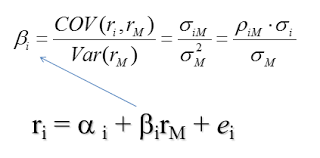

In [73]:
# 위험 자산과 시간 구간을 명시
RISKY_ASSET = 'AMZN'
MARKET_BENCHMARK = '^GSPC'

START_DATE = '2017-01-01'
END_DATE = '2021-12-31'

In [74]:
# 데이터 다운로드
df = yf.download([RISKY_ASSET, MARKET_BENCHMARK],
                 start=START_DATE,
                 end=END_DATE,
                 adjusted=True,
                 progress=False)

print(f'Downloaded {df.shape[0]} rows of data.')

Downloaded 1258 rows of data.


In [75]:
# 월별 데이터로 리샘플링 / 단순 수익률 계산
X = df['Adj Close'].rename(columns={RISKY_ASSET: 'asset', 
                                    MARKET_BENCHMARK: 'market'})\
                                    .resample('M').last()\
                                    .pct_change()\
                                    .dropna()

In [76]:
X.head()

,asset,market
Date,,
2017-02-28,0.026182,0.037198
2017-03-31,0.049110,-0.000389
2017-04-30,0.043371,0.009091
2017-05-31,0.075276,0.011576
2017-06-30,-0.026764,0.004814


In [77]:
# 공분산 기법으로 beta 계산
covariance = X.cov().iloc[0, 1]
benchmark_variance = X.market.var()
beta = covariance / benchmark_variance

print(beta)

1.0954994782733851


In [78]:
# CAPM을 선형 회귀로 추정
y = X.pop('asset')
X = sm.add_constant(X)

capm_model = sm.OLS(y, X).fit()

print(capm_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  asset   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.363
Method:                 Least Squares   F-statistic:                     34.11
Date:                Sat, 06 Aug 2022   Prob (F-statistic):           2.62e-07
Time:                        07:47:52   Log-Likelihood:                 79.442
No. Observations:                  59   AIC:                            -154.9
Df Residuals:                      57   BIC:                            -150.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0123      0.009      1.413      0.1

## 0이 아닌 무위험 금리를 고려하는 방법

### 예컨대 13주 국채를 사용해 무위험 금리를 추정하는 것

In [79]:
# 기간을 일로 정의
N_DAYS = 90

In [80]:
# 데이터 다운로드
df_rf = yf.download('^IRX', start=START_DATE, end=END_DATE)

[*********************100%***********************]  1 of 1 completed


In [81]:
# 월간 주기로 리샘플링
rf = df_rf.resample('M').last().Close / 100

In [82]:
# 무위험 수익률(일별 값으로 표현)을 계산하고 월별로 변환
rf = (1 / (1- - rf * N_DAYS / 360))**(1 / N_DAYS)
rf = (rf ** 30) - 1

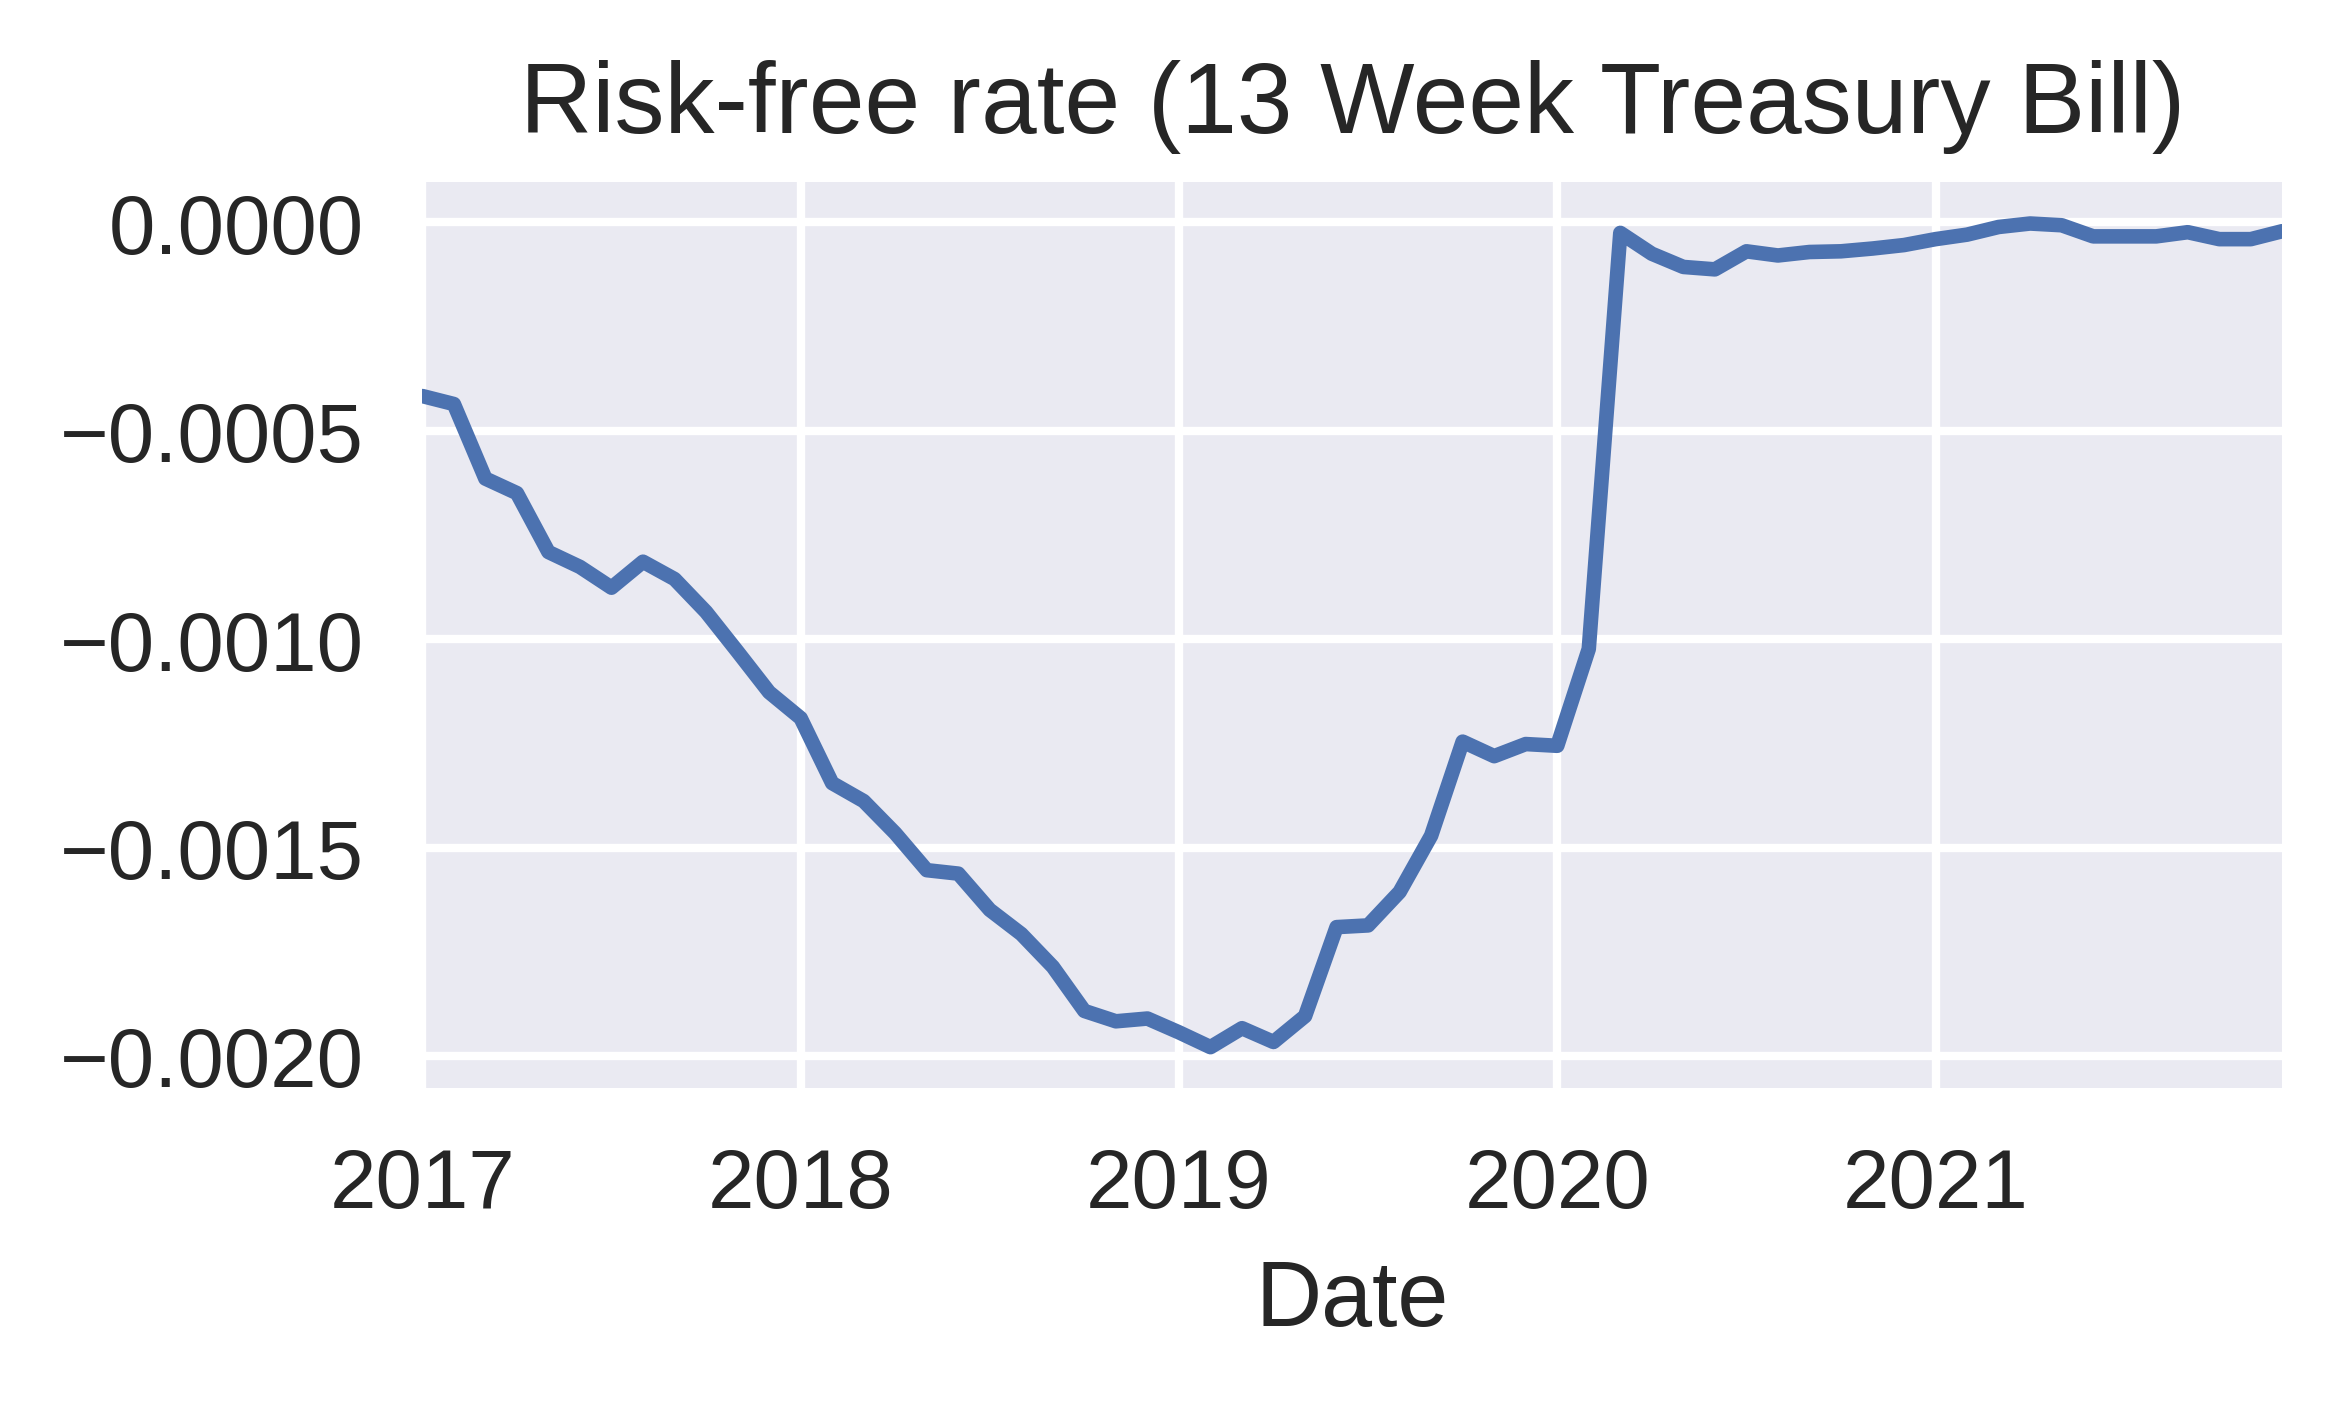

In [83]:
rf.plot(title='Risk-free rate (13 Week Treasury Bill)')

### FRED 데이터베이스에서 다운로드 할 수 있는 3개월 국채를 사용해 무위험 금리를 추정

In [84]:
# FRED 데이터베이스에서 데이터를 다운로드
rf = web.DataReader('TB3MS',
                    'fred',
                    start=START_DATE,
                    end=END_DATE)

In [85]:
# 구한 무위험 금리를 월별 값으로 변환
rf = (1 + (rf / 100)) ** (1 / 12) - 1

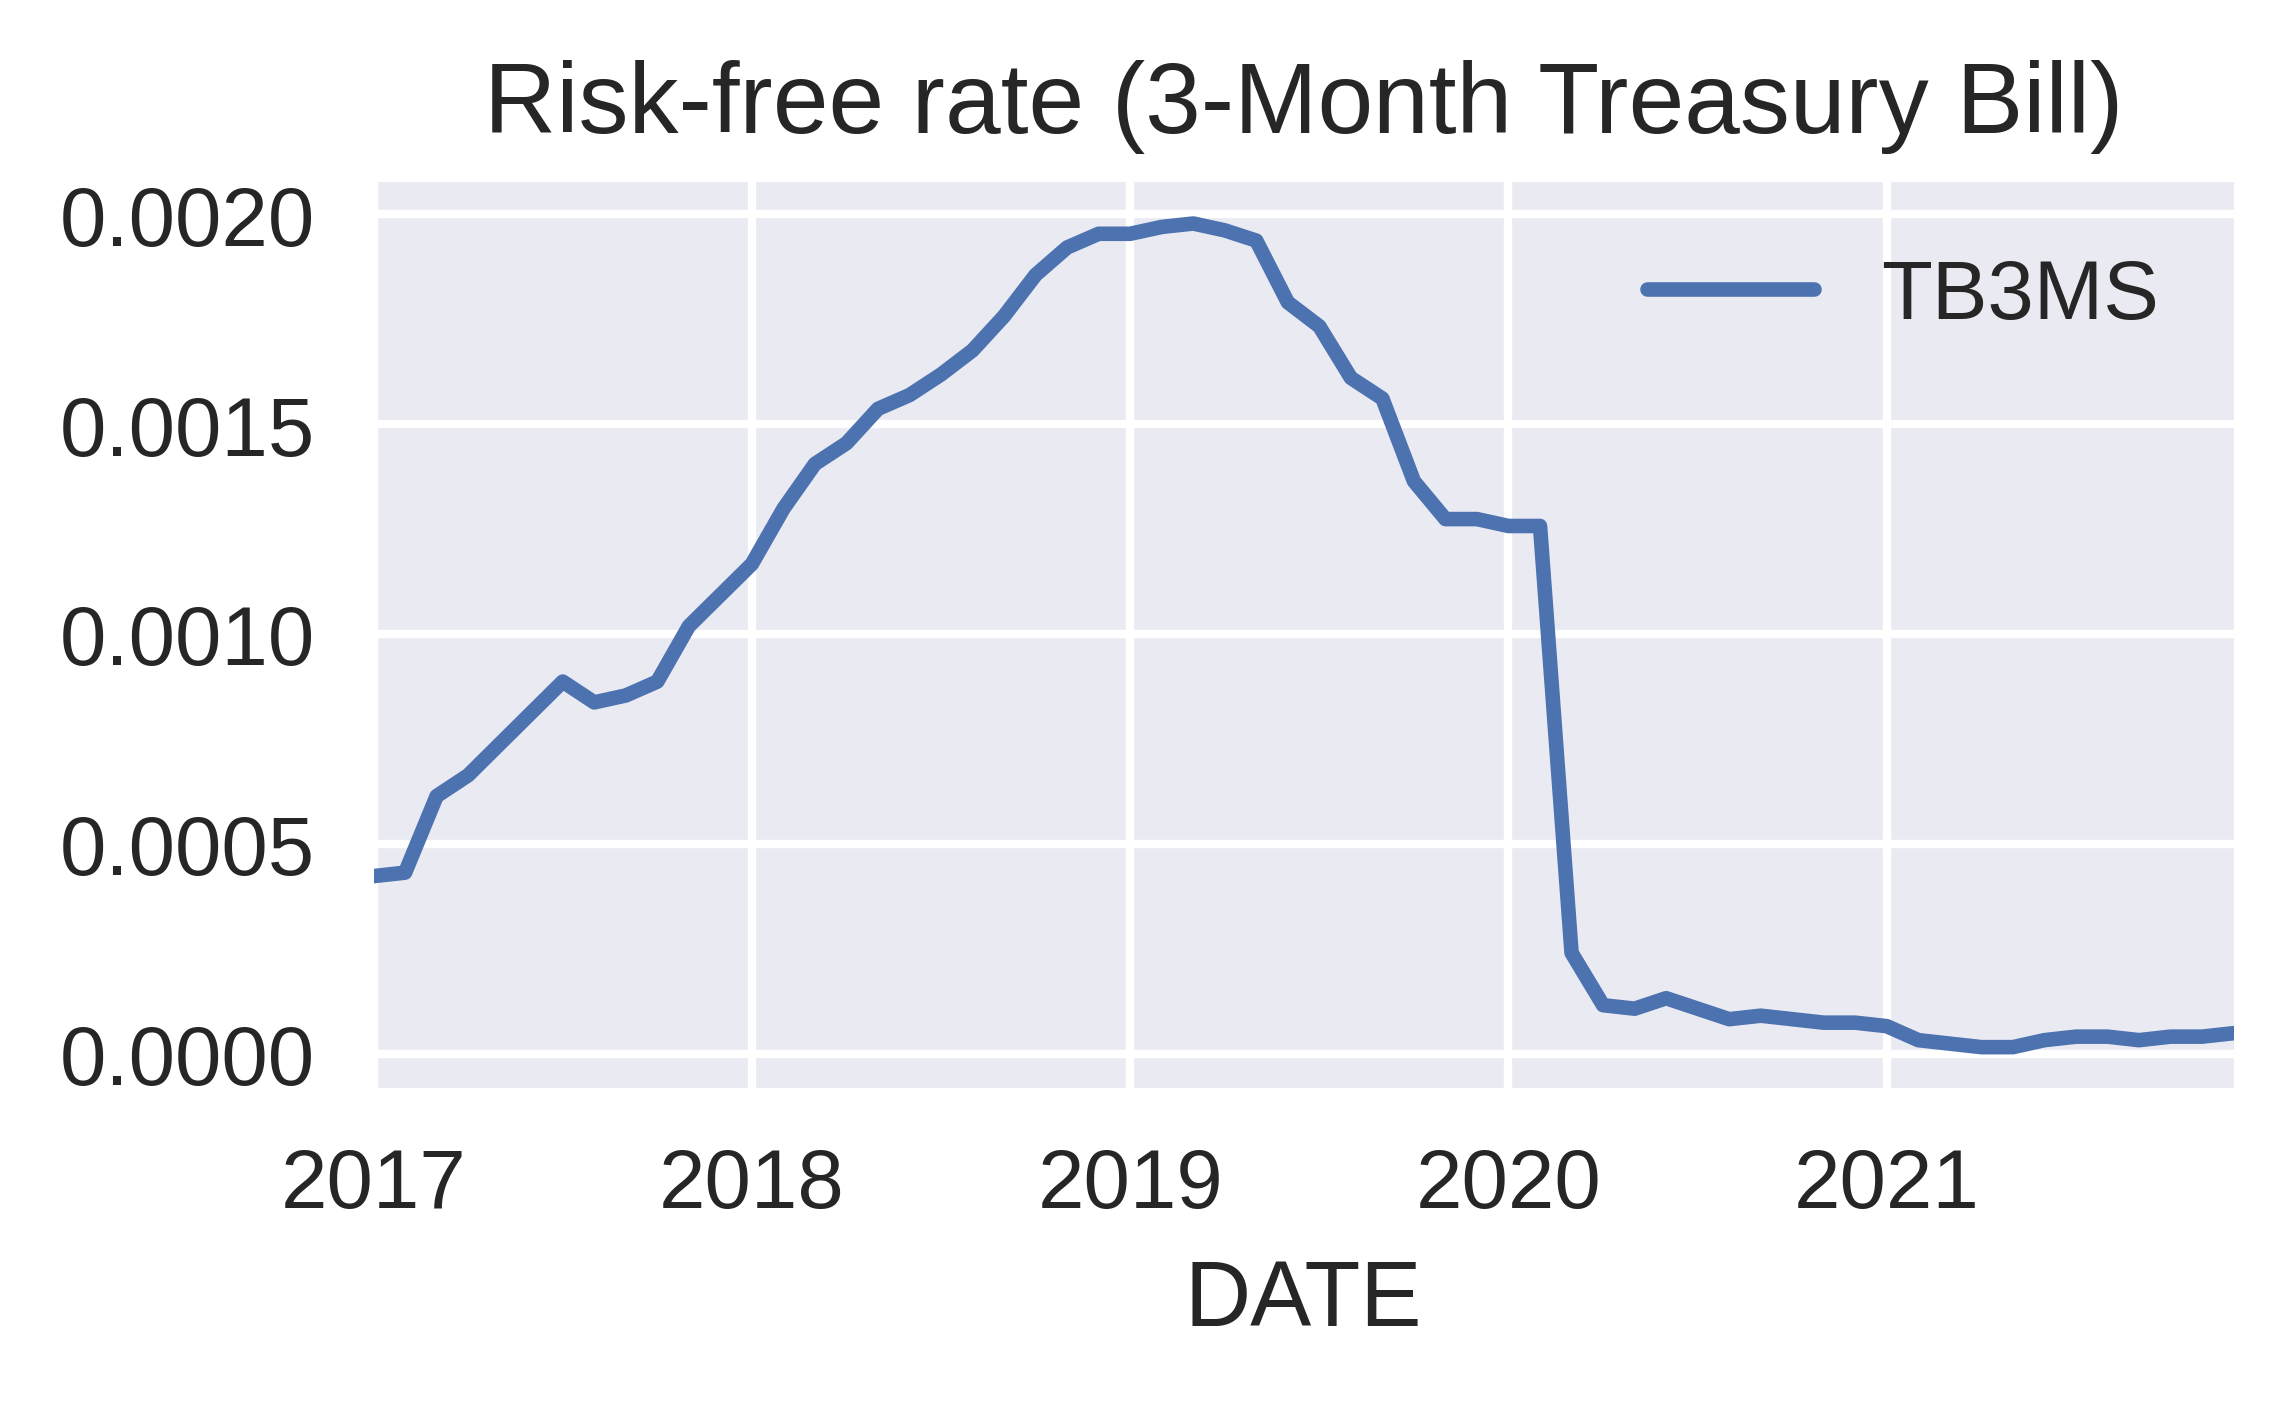

In [86]:
rf.plot(title='Risk-free rate (3-Month Treasury Bill)')

# 파이썬으로 파마-프렌치 3-팩터 모델 구현

**파마-프렌치 3-팩터 모델**

* 자산이나 포트포리오의 초과 수익을 설명하는 두 가지 팩터를 추가해 CAPM 모델을 확장시킴


**고려한 팩터**

* *시장 팩터* : CAPM과 유사한 시장의 초과 수익률을 추정
* *크기 팩터* : 시가 총액이 큰 주식 대비 시가 총액이 작은 주식의 초과 수익률을 측정
* *가치 팩터* : 성장 주식 대비 초과 가치 주식의 초과 수익률을 측정한다. 가치 주식은 높은 시장가-대비-장부가 비율을 갖고 성장 주식은 그 비율이 낮다

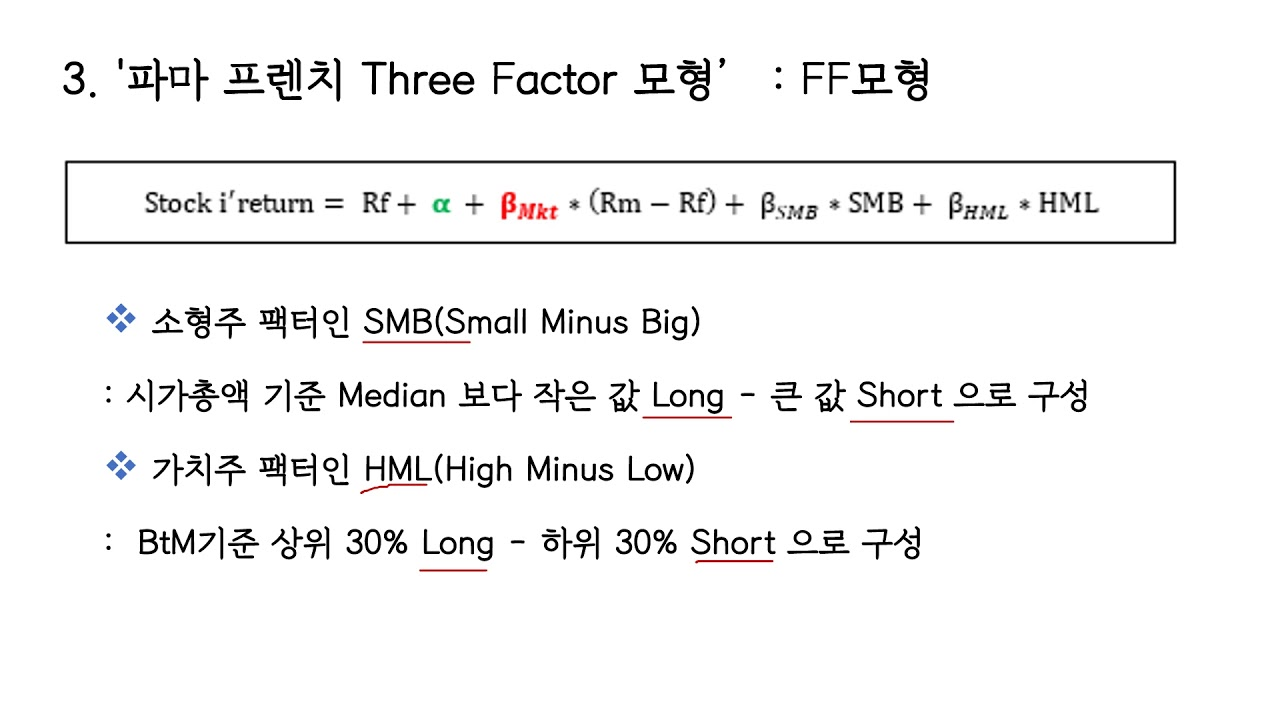

In [87]:
# 프렌치 교수인 웹사이트에서 다운로드
!wget http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip

# zip 풀기
!unzip -a F-F_Research_Data_Factors_CSV.zip

--2022-08-06 07:48:05--  http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip
Resolving mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)... 129.170.171.144
Connecting to mba.tuck.dartmouth.edu (mba.tuck.dartmouth.edu)|129.170.171.144|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12612 (12K) [application/x-zip-compressed]
Saving to: ‘F-F_Research_Data_Factors_CSV.zip.1’

F-F_Research_Data_F 100%[===================>]  12.32K  --.-KB/s    in 0s      

2022-08-06 07:48:05 (56.4 MB/s) - ‘F-F_Research_Data_Factors_CSV.zip.1’ saved [12612/12612]

Archive:  F-F_Research_Data_Factors_CSV.zip
replace F-F_Research_Data_Factors.CSV? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: F-F_Research_Data_Factors.CSV  [binary]


In [88]:
RISKY_ASSET = 'FB'
START_DATE = '2016-12-31'
END_DATE = '2021-12-31'

file_path = '/content/F-F_Research_Data_Factors.CSV'

In [89]:
# 데이터를 로드
factor_df = pd.read_csv(file_path, skiprows=3)

STR_TO_MATCH = ' Annual Factors: January-December '
indices = factor_df.iloc[:, 0] == STR_TO_MATCH
start_of_annual = factor_df[indices].index[0]

# 월별 데이터만 남김
factor_df = factor_df[factor_df.index < start_of_annual]

In [90]:
# column 이름 바꾸기
factor_df.columns = ['date', 'mkt', 'smb', 'hml', 'rf']

factor_df['date'] = pd.to_datetime(factor_df['date'], 
                                   format='%Y%m').dt.strftime("%Y-%m")

# 인덱스 지정
factor_df = factor_df.set_index('date')

factor_df = factor_df.loc[START_DATE:END_DATE]

In [91]:
# 값을 수치로 바꾸고 100으로 나눈다
factor_df = factor_df.apply(pd.to_numeric, errors='coerce').div(100)

In [92]:
factor_df.head()

,mkt,smb,hml,rf
date,,,,
2017-01,0.0194,-0.0116,-0.0273,0.0004
2017-02,0.0357,-0.0205,-0.0166,0.0004
2017-03,0.0017,0.0113,-0.0337,0.0003
2017-04,0.0109,0.0072,-0.0215,0.0005
2017-05,0.0106,-0.0255,-0.0376,0.0006


In [93]:
# 위험 자산의 가격 다운로드
asset_df = yf.download(RISKY_ASSET,
                       start=START_DATE,
                       end=END_DATE,
                       adjusted=True,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 1258 rows of data.


In [94]:
# 위험 자산에 대해 월별 수익률을 계산
y = asset_df['Adj Close'].resample('M') \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.strftime('%Y-%m')
y.name = 'rtn'

In [95]:
y.head()

Date
2017-02    0.040055
2017-03    0.048030
2017-04    0.057726
2017-05    0.008053
2017-06   -0.003169
Name: rtn, dtype: float64

In [96]:
# 데이터 셋을 병합하고 초과 수익률을 계산

ff_data = factor_df.join(y)
ff_data['excess_rtn'] = ff_data.rtn - ff_data.rf

**유의 사항**

* 절편이 양이면서 통계적으로 유의한가?
* 어떤 팩터가 통계적으로 유의하며 방향성이 과거 결과나 가정들에 매칭되는가?

In [97]:
# 3-팩터 모델을 추정
ff_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml', data=ff_data).fit()

print(ff_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     18.02
Date:                Sat, 06 Aug 2022   Prob (F-statistic):           2.86e-08
Time:                        07:50:58   Log-Likelihood:                 84.229
No. Observations:                  59   AIC:                            -160.5
Df Residuals:                      55   BIC:                            -152.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0005      0.008     -0.061      0.9

## pandas_datareader 기능 사용

In [98]:
# 사용할 수 있는 데이터셋
get_available_datasets()[:10]

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily',
 'Portfolios_Formed_on_ME',
 'Portfolios_Formed_on_ME_Wout_Div',
 'Portfolios_Formed_on_ME_Daily',
 'Portfolios_Formed_on_BE-ME',
 'Portfolios_Formed_on_BE-ME_Wout_Div']

In [99]:
# 선택된 데이터셋을 다운로드
ff_dict = web.DataReader('F-F_Research_Data_Factors',
                         'famafrench', 
                         start='2016-01-01')

In [100]:
ff_dict.keys()

dict_keys([0, 1, 'DESCR'])

In [101]:
print(ff_dict['DESCR'])

F-F Research Data Factors
-------------------------

This file was created by CMPT_ME_BEME_RETS using the 202206 CRSP database. The 1-month TBill return is from Ibbotson and Associates, Inc. Copyright 2022 Kenneth R. French

  0 : (78 rows x 4 cols)
  1 : Annual Factors: January-December (6 rows x 4 cols)


In [102]:
ff_dict[0].head()

,Mkt-RF,SMB,HML,RF
Date,,,,
2016-01,-5.77,-3.39,2.06,0.01
2016-02,-0.07,0.81,-0.57,0.02
2016-03,6.96,0.76,1.10,0.02
2016-04,0.91,0.67,3.21,0.01
2016-05,1.78,-0.19,-1.66,0.01


# 자산 포트폴리오에 롤링 3-팩터 모델 구현

In [103]:
ASSETS = ['AMZN', 'GOOG', 'AAPL', 'MSFT']
WEIGHTS = [0.25, 0.25, 0.25, 0.25]
START_DATE = '2012-12-31'
END_DATE = '2021-12-31'

In [104]:
# 팩터 관련 데이터 다운로드
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', 
                                 start=START_DATE)[0]

df_three_factor = df_three_factor.div(100)

df_three_factor.index = df_three_factor.index.format()

In [105]:
# 위험 자산 가격 다운로드
asset_df = yf.download(ASSETS,
                       start=START_DATE,
                       end=END_DATE,
                       adjusted=True,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 2267 rows of data.


In [106]:
# 위험 자산에 대한 월별 수익률 계산
asset_df = asset_df['Adj Close'].resample('M') \
                                .last() \
                                .pct_change() \
                                .dropna()

asset_df.index = asset_df.index.strftime('%Y-%m')

In [107]:
# 포트폴리오 수익률 계산
asset_df['portfolio_returns'] = np.matmul(asset_df[ASSETS].values, WEIGHTS)

In [108]:
asset_df.head()

,AAPL,AMZN,GOOG,MSFT,portfolio_returns
Date,,,,,
2013-01,-0.144089,0.058317,0.068294,0.027705,0.002557
2013-02,-0.025286,-0.004633,0.060223,0.021135,0.012860
2013-03,0.002854,0.008401,-0.008749,0.029137,0.007911
2013-04,0.000271,-0.047582,0.038253,0.156938,0.036970
2013-05,0.022419,0.060636,0.056575,0.061774,0.050351


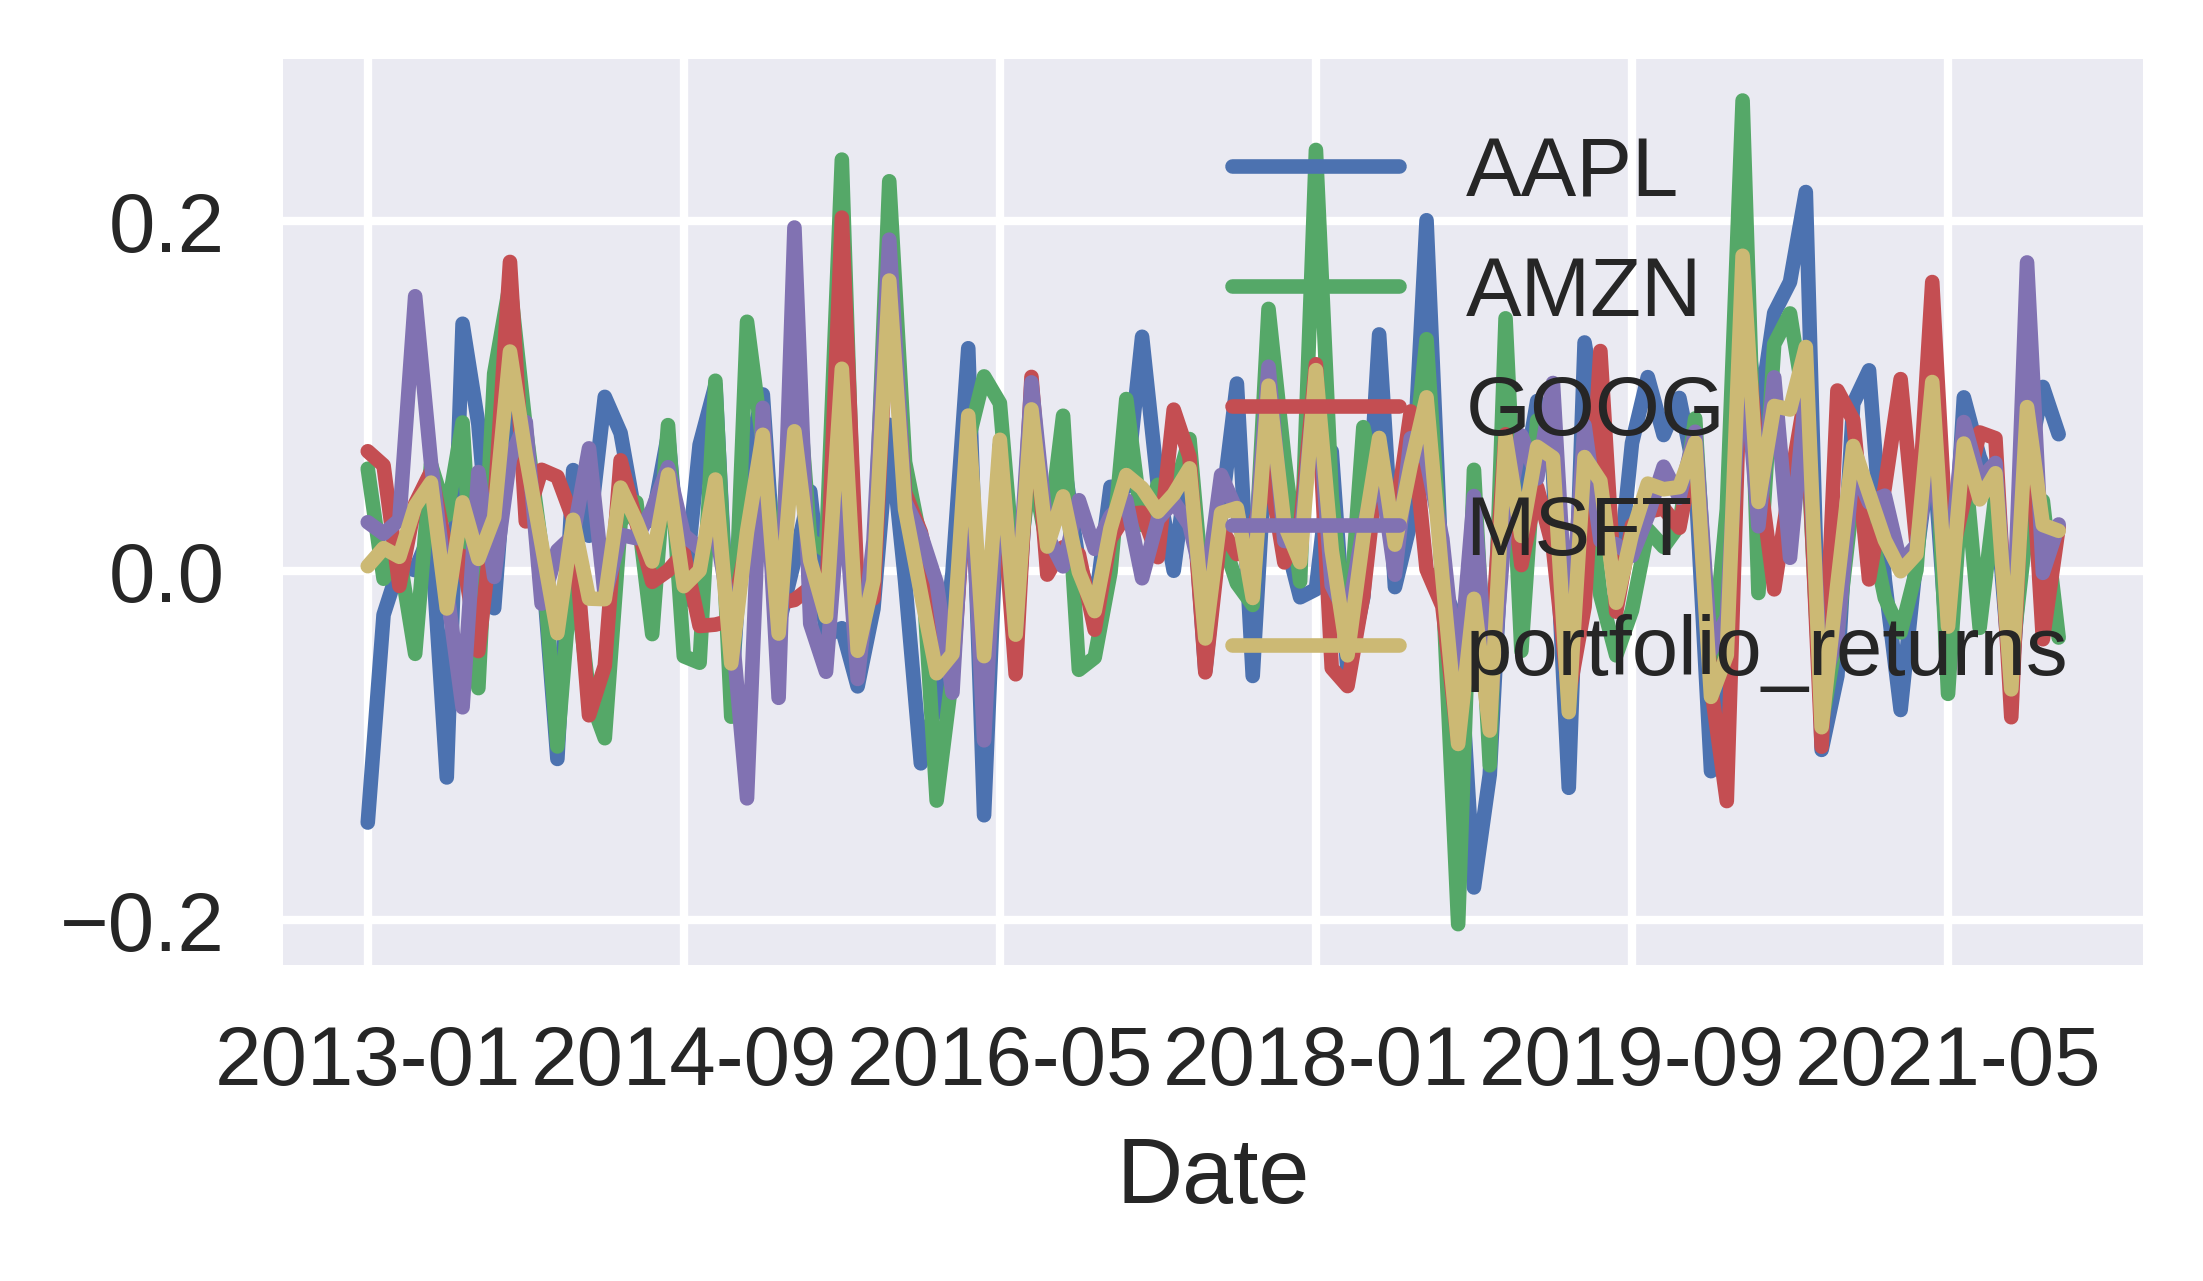

In [109]:
asset_df.plot()

In [110]:
# 데이터셋 병합
ff_data = asset_df.join(df_three_factor).drop(ASSETS, axis=1)
ff_data.columns = ['portf_rtn', 'mkt', 'smb', 'hml', 'rf']
ff_data['portf_ex_rtn'] = ff_data.portf_rtn - ff_data.rf

In [111]:
ff_data.head()

,portf_rtn,mkt,smb,hml,rf,portf_ex_rtn
Date,,,,,,
2013-01,0.002557,0.0557,0.0031,0.0095,0.0,0.002557
2013-02,0.012860,0.0129,-0.0033,0.0010,0.0,0.012860
2013-03,0.007911,0.0403,0.0083,-0.0023,0.0,0.007911
2013-04,0.036970,0.0155,-0.0236,0.0050,0.0,0.036970
2013-05,0.050351,0.0280,0.0172,0.0267,0.0,0.050351


In [112]:
# 롤링 n-팩터 모델의 함수 정의
def rolling_factor_model(input_data, formula, window_size):

  coeffs = []

  for start_index in range(len(input_data) - window_size + 1):

    end_index = start_index + window_size

    ff_model = smf.ols(
        formula=formula,
        data=input_data[start_index:end_index]
    ).fit()

    coeffs.append(ff_model.params)

  coeffs_df = pd.DataFrame(
      coeffs,
      index=input_data.index[window_size - 1:]
  )

  return coeffs_df

In [113]:
MODEL_FORMULA = 'portf_ex_rtn ~ mkt + smb + hml'

results_df = rolling_factor_model(ff_data, 
                                  MODEL_FORMULA, 
                                  window_size=60)

In [115]:
results_df.head()

,Intercept,mkt,smb,hml
Date,,,,
2017-12,0.006710,1.196930,-0.719219,-0.585738
2018-01,0.007038,1.265574,-0.741720,-0.566515
2018-02,0.008559,1.219149,-0.723307,-0.581405
2018-03,0.008998,1.245814,-0.718552,-0.585578
2018-04,0.009385,1.243609,-0.717463,-0.581789


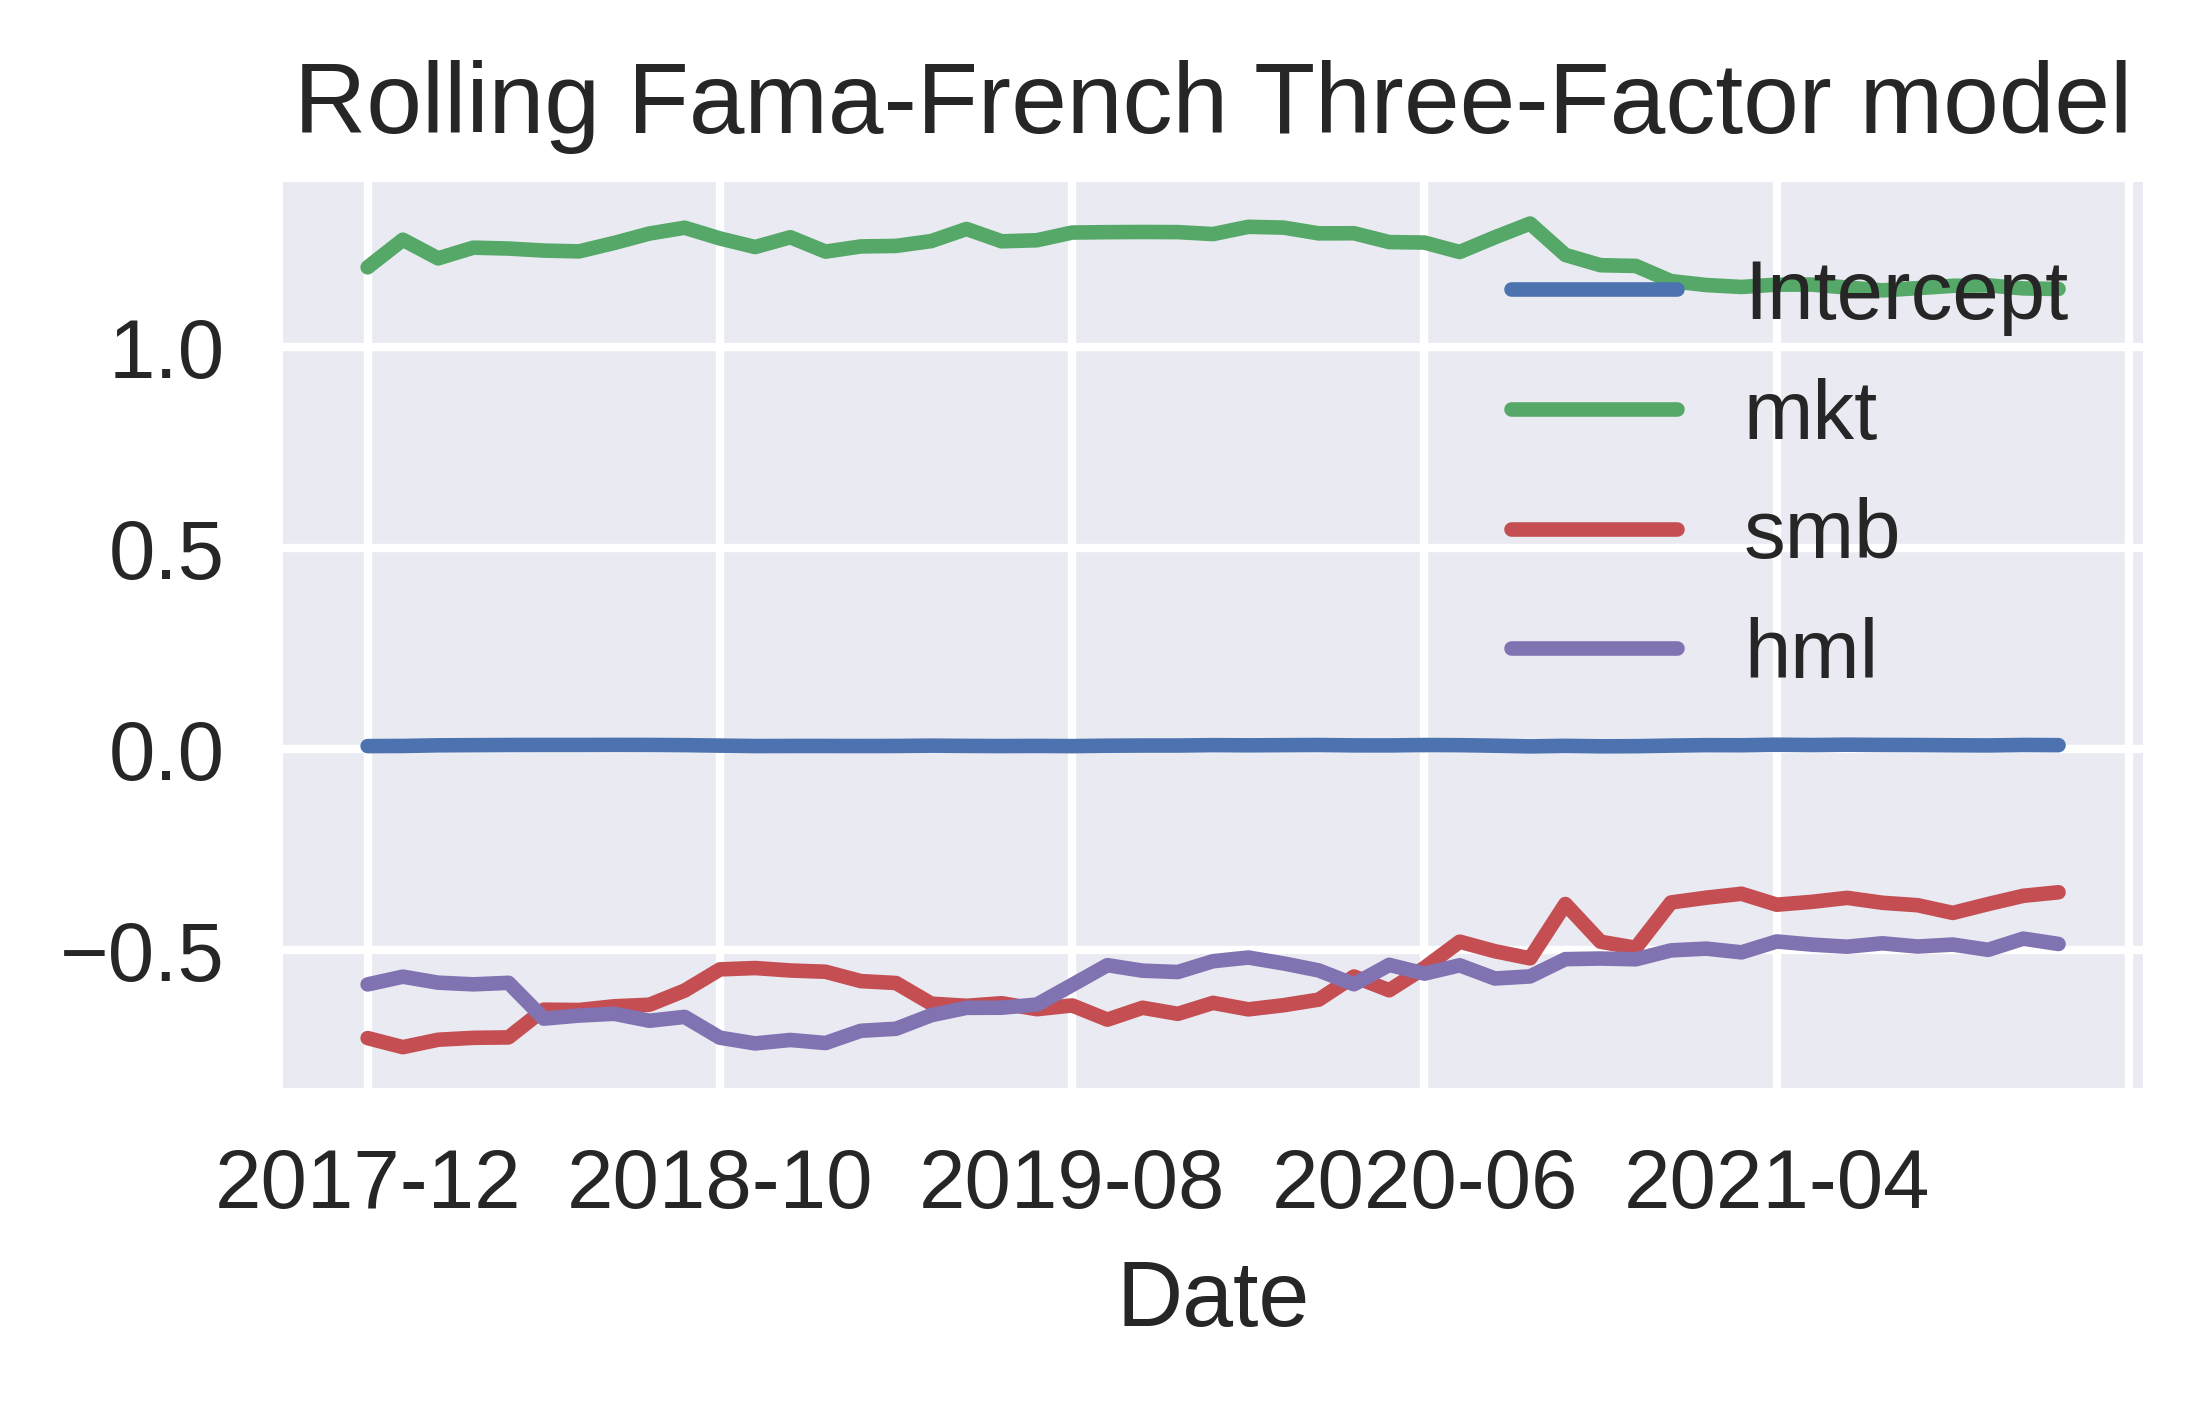

In [114]:
results_df.plot(title = 'Rolling Fama-French Three-Factor model')

# 파이썬으로 4-팩터와 5-팩터 모델 구현

**카하트의 4-팩터 모델**

* 기본 가정 : 단기간에는 승자 주식은 승자로 남고 패자는 패자로 남는다
* 두 그룹을 식별한 후 특정 보유 기간 내에 승자를 매수하고 패자를 매도한다


**모멘텀 팩터**

* 과거 12개월 동안의 패자 주식에 대한 승자 주식의 초과 수익을 측정한다

**파마-프렌치의 5-팩터 모델**

* RMW : 이윤이 낮은 회사에 비해 이윤이 높은 회사의 초과 수익률을 측정
* CMA : 저투자 회사의 중급 이상 투자 정책회사 대비 초과 이익률을 측정

In [116]:
RISKY_ASSET = 'AMZN'
START_DATE = '2016-12-31'
END_DATE = '2021-12-31'

In [117]:
# 3-팩터
df_three_factor = web.DataReader('F-F_Research_Data_Factors', 'famafrench', 
                                 start=START_DATE)[0]

df_three_factor.index = df_three_factor.index.format()

# 모멘텀 팩터
df_mom = web.DataReader('F-F_Momentum_Factor', 'famafrench', 
                        start=START_DATE)[0]

df_mom.index = df_mom.index.format()

# 5-팩터
df_five_factor = web.DataReader('F-F_Research_Data_5_Factors_2x3', 
                                'famafrench', 
                                start=START_DATE)[0]
                                
df_five_factor.index = df_five_factor.index.format()

In [118]:
# 데이터 다운로드
asset_df = yf.download(RISKY_ASSET,
                       start=START_DATE,
                       end=END_DATE,
                       adjusted=True,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 1258 rows of data.


In [119]:
# 월별 수익률 계산
y = asset_df['Adj Close'].resample('M') \
                         .last() \
                         .pct_change() \
                         .dropna()

y.index = y.index.strftime('%Y-%m')
y.name = 'return'

In [120]:
y.head()

Date
2017-02    0.026182
2017-03    0.049110
2017-04    0.043371
2017-05    0.075276
2017-06   -0.026764
Name: return, dtype: float64

In [123]:
# 4-팩터 요인을 위한 데이터셋을 병합

# 모든 데이터셋을 인덱스에 조인
four_factor_data = df_three_factor.join(df_mom).join(y)

# 컬럼 명 변경
four_factor_data.columns = ['mkt', 'smb', 'hml', 'rf', 'mom', 'rtn']

# 수익률을 제외하고 100으로 나눔
four_factor_data.loc[:, four_factor_data.columns != 'rtn'] /= 100

# 관심 대상 기간 설정
four_factor_data = four_factor_data.loc[START_DATE:END_DATE]

# 초과 수익률 계산
four_factor_data['excess_rtn'] = four_factor_data.rtn - four_factor_data.rf

In [124]:
four_factor_data.head()

,mkt,smb,hml,rf,mom,rtn,excess_rtn
2017-01,0.0194,-0.0116,-0.0273,0.0004,-0.0093,NaN,NaN
2017-02,0.0357,-0.0205,-0.0166,0.0004,-0.0165,0.026182,0.025782
2017-03,0.0017,0.0113,-0.0337,0.0003,-0.0102,0.049110,0.048810
2017-04,0.0109,0.0072,-0.0215,0.0005,0.0048,0.043371,0.042871
2017-05,0.0106,-0.0255,-0.0376,0.0006,0.0148,0.075276,0.074676


In [126]:
# 5-팩터 모델을 위한 데이터셋 병합

# 모든 데이터셋을 인덱스에 조인
five_factor_data = df_five_factor.join(y)

# 컬럼 명 변경
five_factor_data.columns = ['mkt', 'smb', 'hml', 'rmw', 'cma', 'rf', 'rtn']

# 수익률을 제외하고 100으로 나눔
five_factor_data.loc[:, five_factor_data.columns != 'rtn'] /= 100

# 관심 대상 기간 설정
five_factor_data = five_factor_data.loc[START_DATE:END_DATE]

# 초과 수익률 계산
five_factor_data['excess_rtn'] = five_factor_data.rtn - five_factor_data.rf

In [127]:
five_factor_data.head()

,mkt,smb,hml,rmw,cma,rf,rtn,excess_rtn
2017-01,0.0194,-0.0143,-0.0273,-0.0050,-0.0098,0.0004,NaN,NaN
2017-02,0.0357,-0.0223,-0.0166,0.0044,-0.0183,0.0004,0.026182,0.025782
2017-03,0.0017,0.0074,-0.0337,0.0063,-0.0094,0.0003,0.049110,0.048810
2017-04,0.0109,0.0047,-0.0215,0.0191,-0.0161,0.0005,0.043371,0.042871
2017-05,0.0106,-0.0304,-0.0376,0.0095,-0.0179,0.0006,0.075276,0.074676


In [128]:
# 4-팩터 모델 추정
four_factor_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml + mom', 
                            data=four_factor_data).fit()

print(four_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                     17.84
Date:                Sat, 06 Aug 2022   Prob (F-statistic):           2.18e-09
Time:                        08:15:52   Log-Likelihood:                 90.398
No. Observations:                  59   AIC:                            -170.8
Df Residuals:                      54   BIC:                            -160.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0019      0.008      0.251      0.8

In [129]:
# 5-팩터 모델 추정
five_factor_model = smf.ols(
    formula='excess_rtn ~ mkt + smb + hml + rmw + cma', 
    data=five_factor_data
).fit()

print(five_factor_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     13.62
Date:                Sat, 06 Aug 2022   Prob (F-statistic):           1.50e-08
Time:                        08:17:15   Log-Likelihood:                 89.932
No. Observations:                  59   AIC:                            -167.9
Df Residuals:                      53   BIC:                            -155.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0041      0.008      0.511      0.6